In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm

from pylab import rcParams

import os
import re
import time

seed = 9001
np.random.seed(seed)

c:\users\antra\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Create function to load individual patient data into one big dataframe

In [31]:
# only extracts numbers from file name to use as patient number
regex = re.compile(r'\d+')

DATA_DIR = "training" # Path to the data

def load_single_file(file_path):
    df = pd.read_csv(file_path, sep='|')
    df['hour'] = df.index
    patient = regex.findall(file_path)
    df['patient'] = int(patient[0]) # extracts only numbers from file name
    return df 

def get_data_files():
    return [os.path.join(DATA_DIR, x) for x in sorted(os.listdir(DATA_DIR))]

def clean_data(data):
    data.reset_index(inplace=True, drop=True) # reset the index pre-joined dataframes
    return data

def load_data():
    df_list = list()
    files = get_data_files()

    for file in files:
        df_list.append(load_single_file(file))
    
    # create patient id ordered starting from 0
    for i in np.arange(0, len(df_list)):
        df_list[i]['id'] = i
    
    df = pd.concat(df_list) # concat all the dataframes in this list into 1 big dataframe
    df = clean_data(df) # reset the indices
    df = df.drop(columns=['patient']) # drop patient number since not needed anymore

    return df

(1552210, 43)

In [2]:
# aggregate the individual patient data into one big data frame
df = load_data()

# Data Exploration

In [32]:
df.columns # name of columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'hour', 'id'],
      dtype='object')

In [33]:
df.shape # dataset size: 1,552,210 rows x 43 columns

(1552210, 43)

In [34]:
df['SepsisLabel'].value_counts() # this is per event notes/records. NOT per patients

0    1524294
1      27916
Name: SepsisLabel, dtype: int64

### Distribution of sepsis labels vs total number of events

In [35]:
distribution = (df['SepsisLabel'].value_counts()[1] / sum(df['SepsisLabel'].value_counts()))
print('Distribution of sepsis events: ', distribution*100, '%')

Distribution of sepsis events:  1.798467990800214 %


### Plot the event-wise imbalance

Text(0.5, 1.0, 'Sepsis Label Distribution Event-wise')

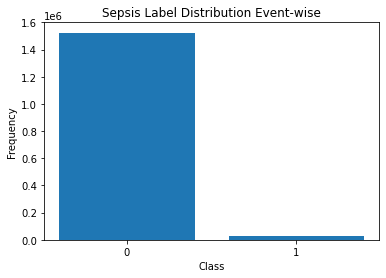

In [36]:
plt.bar(df['SepsisLabel'].value_counts().index, # x-values
        df['SepsisLabel'].value_counts()) # y-values
plt.xticks([0,1])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Sepsis Label Distribution Event-wise')

### Distribution of sepsis patient-wise

In [37]:
grp_sepsis = df.groupby(['id'])['SepsisLabel'].sum() # sum sepsis labels grouped by 'id'. patients with sepsis have sum > 0

len(grp_sepsis[grp_sepsis > 0]) # total number of patients with sepsis

2932

In [38]:
sepsis_distr = len(grp_sepsis[grp_sepsis > 0]) / len(df['id'].unique())
print('Distribution of sepsis patients: ', sepsis_distr*100, '%')

Distribution of sepsis patients:  7.268940896469656 %


### Percentage of missing data per each variable

In [39]:
missing = (df.isnull().sum() / df.shape[0]) * 100
missing_sorted = missing.sort_values() # sorted percentage of missing data variables
missing_sorted

id                   0.000000
SepsisLabel          0.000000
ICULOS               0.000000
Gender               0.000000
Age                  0.000000
hour                 0.000000
HospAdmTime          0.000515
HR                   9.882619
MAP                 12.451279
O2Sat               13.061119
SBP                 14.576958
Resp                15.354559
DBP                 31.345887
Unit2               39.425078
Unit1               39.425078
Temp                66.162697
Glucose             82.894325
Potassium           90.689082
Hct                 91.145979
FiO2                91.665754
Hgb                 92.617558
pH                  93.069688
BUN                 93.134434
WBC                 93.593199
Magnesium           93.689578
Creatinine          93.904433
Platelets           94.059502
Calcium             94.116067
PaCO2               94.440121
BaseExcess          94.579020
Chloride            95.460279
HCO3                95.810618
Phosphate           95.986303
EtCO2     

### Laboratory results features have more than 90% missing data. With such a high amount of missing values, these features are excluded because they do not contain useful information.

### Save features less than 90% missing data

In [40]:
selected_cols = list(missing_sorted[missing_sorted < 90].index)
selected_cols

['id',
 'SepsisLabel',
 'ICULOS',
 'Gender',
 'Age',
 'hour',
 'HospAdmTime',
 'HR',
 'MAP',
 'O2Sat',
 'SBP',
 'Resp',
 'DBP',
 'Unit2',
 'Unit1',
 'Temp',
 'Glucose']

### Exclude Unit1, Unit2, ICULOS, HospAdmTime variables because these are just identifiers

In [41]:
selected_cols = [col for col in selected_cols if col not in ['Unit1', 'Unit2', 'ICULOS', 'HospAdmTime', 'Glucose']] # exclude glucose because it's a laboratory feature

In [42]:
selected_cols

['id',
 'SepsisLabel',
 'Gender',
 'Age',
 'hour',
 'HR',
 'MAP',
 'O2Sat',
 'SBP',
 'Resp',
 'DBP',
 'Temp']

In [43]:
filter_df = df[selected_cols]

In [44]:
filter_df.shape # 1,552,210 rows x 15 variables 

(1552210, 12)

In [45]:
filter_df.head()

,id,SepsisLabel,Gender,Age,hour,HR,MAP,O2Sat,SBP,Resp,DBP,Temp
0,0,0,0,83.14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,83.14,1,97.0,75.33,95.0,98.0,19.0,NaN,NaN
2,0,0,0,83.14,2,89.0,86.00,99.0,122.0,22.0,NaN,NaN
3,0,0,0,83.14,3,90.0,NaN,95.0,NaN,30.0,NaN,NaN
4,0,0,0,83.14,4,103.0,91.33,88.5,122.0,24.5,NaN,NaN


In [46]:
categorical = filter_df.dtypes == object
categorical['Gender'] = True # consider Gender as the categorical variable

In [47]:
cat_vars = list(categorical[categorical].index) # categorical variables
cont_vars = list(categorical[~categorical].index) # continuous variables
cont_vars = [var for var in cont_vars if var not in ['id', 'SepsisLabel', 'hour']] # exclude these variables from physiological signals

In [48]:
cont_vars

['Age', 'HR', 'MAP', 'O2Sat', 'SBP', 'Resp', 'DBP', 'Temp']

### Boxplot of different variables between sepsis and non-sepsis patients

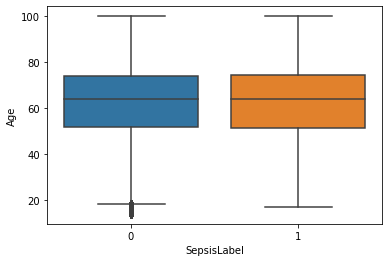

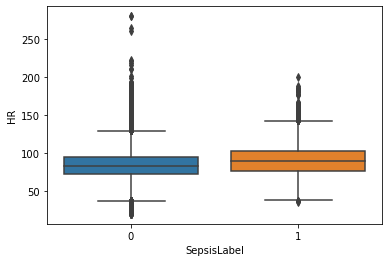

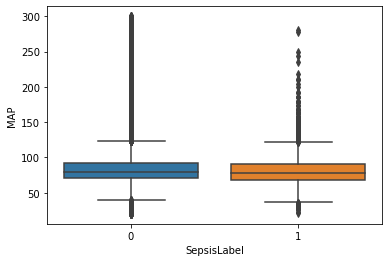

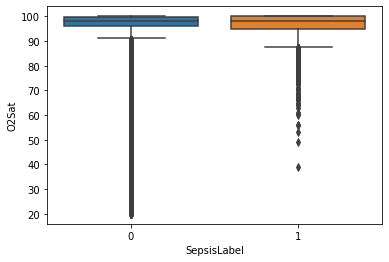

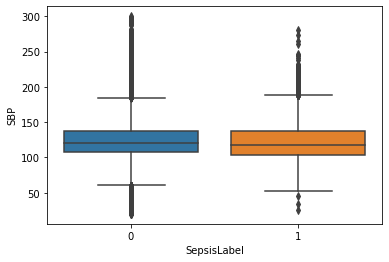

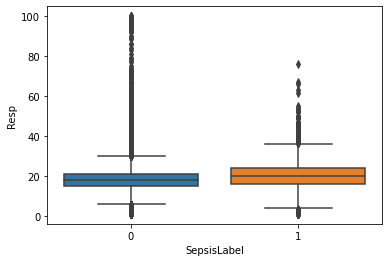

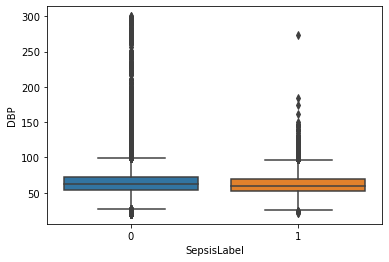

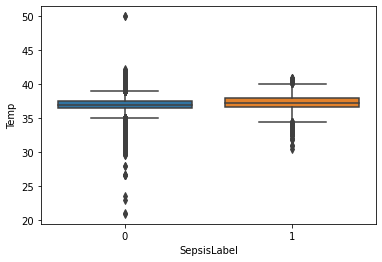

In [27]:
import seaborn as sns

for i, var in enumerate(cont_vars):
  plt.figure(i)
  ax = sns.boxplot(x="SepsisLabel", y=var, data=filter_df)

### Imputation with interpolation, forward and backward fill

In [49]:
# fill using interpolation for the missing values in-between
# interpolate: using numbers from 2 ends to infer the missing data in-between

X = filter_df.interpolate(method='nearest', limit_direction='both')
X = X.ffill().bfill() # forward fill first, then backward fill

In [50]:
missing = (X.isnull().sum() / X.shape[0]) * 100
missing

id             0.0
SepsisLabel    0.0
Gender         0.0
Age            0.0
hour           0.0
HR             0.0
MAP            0.0
O2Sat          0.0
SBP            0.0
Resp           0.0
DBP            0.0
Temp           0.0
dtype: float64

### Save this processed data for later access

In [0]:
X.to_csv('non_temporal_processed.csv', index=False)

In [51]:
signals = ['HR', 'MAP', 'O2Sat', 'SBP', 'Resp', 'DBP', 'Temp', 'id'] # include 'id' to perform groupby

In [52]:
demographics = [var for var in X if var not in signals]

In [53]:
demographics

['SepsisLabel', 'Gender', 'Age', 'hour']

### Return some ID's of the patients that get sepsis

In [54]:
sepsis_id = X.loc[X['SepsisLabel'] == 1]['id'].unique()

In [55]:
# returns the first 10 patients with sepsis
sepsis_id[:20]

array([  8,  10,  14,  17,  21,  27,  33,  41,  52,  55,  57,  62,  63,
        77, 140, 160, 170, 177, 184, 187])

### Plot a sample Heart Rate between a sepsis and non-sepsis patient to see the difference in pattern over time

In [56]:
rcParams['figure.figsize'] = 10, 10

In [57]:
# # Function to map the colors as a list from the input list of x variables
colors = {1: 'red', 0: '#1f77b4'}

Text(0.5, 1.0, 'Heart Rate of A Non-Sepsis Patient Over Time')

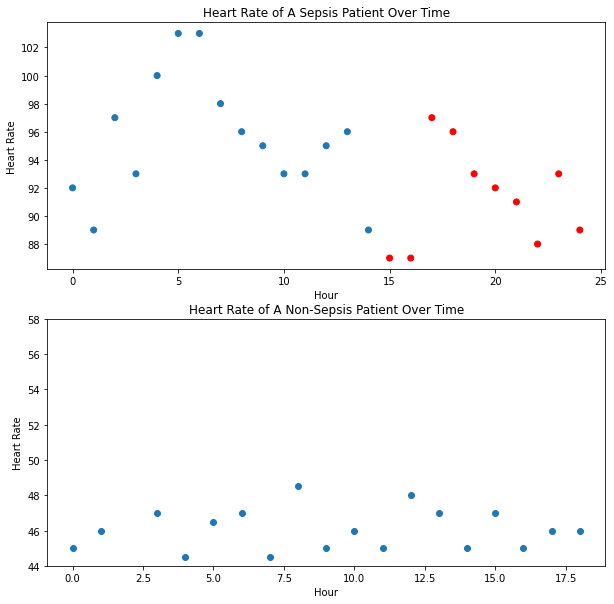

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(X[X['id']==52]['hour'].values, X[X['id']==52]['HR'], c = X[X['id']==52]['SepsisLabel'].apply(lambda x: colors[x]))
ax1.set_xlabel('Hour')
ax1.set_ylabel('Heart Rate')
ax1.set_title('Heart Rate of A Sepsis Patient Over Time')

ax2.scatter(X[X['id']==95]['hour'].values, X[X['id']==95]['HR'])
ax2.set_xlabel('Hour')
ax2.set_ylabel('Heart Rate')
ax2.set_ylim([44, 58])
ax2.set_title('Heart Rate of A Non-Sepsis Patient Over Time')

### Plot Mean Arterial Pressure (MAP) of the same sepsis and non-sepsis patient

In [0]:
rcParams['figure.figsize'] = 10, 10

In [0]:
# # Function to map the colors as a list from the input list of x variables
colors = {1: 'red', 0: '#1f77b4'}

Text(0.5, 1.0, 'Mean Arterial Pressure of A Non-Sepsis Patient Over Time')

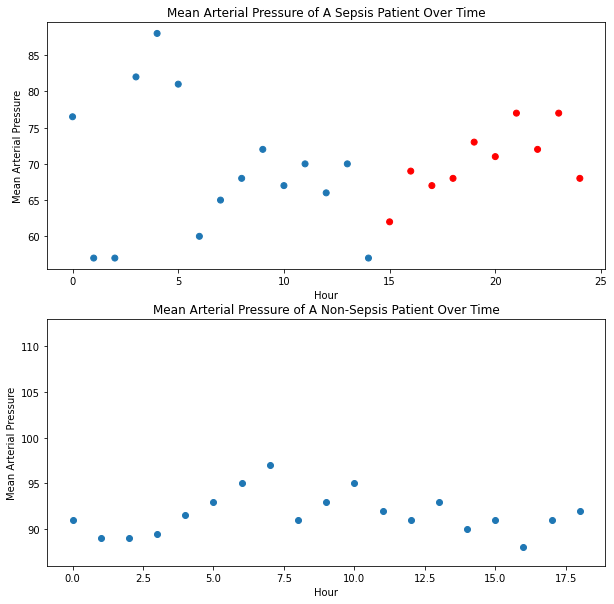

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(X[X['id']==52]['hour'].values, X[X['id']==52]['MAP'], c = X[X['id']==52]['SepsisLabel'].apply(lambda x: colors[x]))
ax1.set_xlabel('Hour')
ax1.set_ylabel('Mean Arterial Pressure')
ax1.set_title('Mean Arterial Pressure of A Sepsis Patient Over Time')


ax2.scatter(X[X['id']==95]['hour'].values, X[X['id']==95]['MAP'])
ax2.set_xlabel('Hour')
ax2.set_ylabel('Mean Arterial Pressure')
ax2.set_ylim([86, 113])
ax2.set_title('Mean Arterial Pressure of A Non-Sepsis Patient Over Time')